In [1]:
import random
import re

from Flamant.default import PROJECT_HOME
%cd {PROJECT_HOME}

C:\Users\louis\PycharmProjects\Master_Thesis\Flamant


In [2]:
from Flamant.dataset.structural.analysis import LinearAnalysis
from Flamant.dataset.structural.structure import PrattTruss
from Flamant.dataset.generator import PrattTrussGenerator
from Flamant.dataset import FixedPrattTrussDataset, FixedPrattTrussDatasetSingleTarget, FixedPrattTrussDatasetThreeTargets
from Flamant.display import *
from scipy.stats.qmc import Sobol
import matplotlib.pyplot as plt
from typing import Dict, Iterable
import numpy as np

277.85


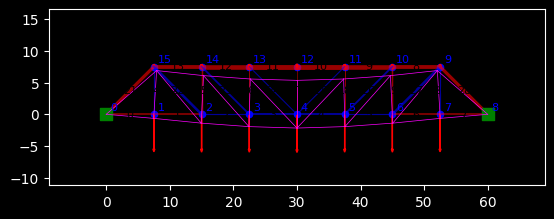

In [3]:
import numpy as np

n_panels = 8
l = 7.5
volumetric_weight = 78.5e3
params = {
    'n_panels': n_panels,
    'height': l,
    'length': n_panels * l,
    'volumetric_weight': volumetric_weight
}

a = .2
a_t = a
a_b = a
a_v = a
a_d = a

e_t = 200e9
e_b = 200e9
e_v = 200e9
e_d = 100e9
# t - top
# b - bottom
# v - vertical
# d - diagonal

for i in range(8):
    params[f"A_{i}"] = a_b
    params[f"E_{i}"] = e_b
for i in range(8, 14):
    params[f"A_{i}"] = a_t
    params[f"E_{i}"] = e_t
for i in range(14, 21):
    params[f"A_{i}"] = a_v
    params[f"E_{i}"] = e_v
params[f"A_21"] = a_t ### SHOULD BE D?
params[f"E_21"] = e_t
for i in range(22, 28):
    params[f"A_{i}"] = a_d
    params[f"E_{i}"] = e_d
params[f"A_28"] = a_t ### SHOULD BE D?
params[f"E_28"] = e_t

for i in range(2 * n_panels):
    params[f"P_x_{i}"] = 0.
    params[f"P_y_{i}"] = 0.

for i in range(1, n_panels):
    params[f"P_y_{i}"] = -10000.e3

struct = PrattTruss(bisupported=True)
struct.generate_model(params)           # in abstract_structure.py, sends back to generate_structure with OpenSees (subclass method)
LinearAnalysis().run_analysis()         # in linear_analysis.py, runs OpenSees linear analysis
g = PrattTrussGenerator()               # in pratt_truss_generator.py, recreates a structures with PrattTruss(bisupported=bisupported)
results = g.construct_result(params)    # construct can access the OpenSees model through the ops. calls. These are in abstract_structure,
                                        # called through abstract_planar_truss where the parent class of PrattTruss is
display_structure(def_scale=10)         # method in osp_display.py that displays an ops structure
print(f"{60 / np.abs(struct.nodes_displacements[:, 1]).max():.2f}")

In [4]:
def plot(g, def_scale=5):
    fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    for i, r in enumerate(g):
        if i >= 6:  # Since we have 2x3=6 subplots
            break

        display_structure(ax=axs[i], def_scale=def_scale)

    # After plotting all structures, adjust all axes to have same limits
    x_min, x_max = float('inf'), float('-inf')
    y_min, y_max = float('inf'), float('-inf')

    # Find global min and max across all subplots
    for ax in axs:
        x_limits = ax.get_xlim()
        y_limits = ax.get_ylim()
        x_min = min(x_min, x_limits[0])
        x_max = max(x_max, x_limits[1])
        y_min = min(y_min, y_limits[0])
        y_max = max(y_max, y_limits[1])

    # Make the scale the same in both directions - take the wider range
    total_range = max(x_max - x_min, y_max - y_min)
    x_center = (x_max + x_min) / 2
    y_center = (y_max + y_min) / 2

    # Apply the same limits to all subplots
    for ax in axs:
        ax.set_xlim(x_center - total_range / 2, x_center + total_range / 2)
        ax.set_ylim(y_center - total_range / 2, y_center + total_range / 2)

        # Ensure aspect ratio is equal
        ax.set_aspect('equal')

    plt.tight_layout()

In [5]:
def sobol_sample(ranges: Dict | Iterable, size, seed=None):
    sampler = Sobol(d=len(ranges), scramble=True, seed=seed)
    sampling = sampler.random(n=size)

    if isinstance(ranges, dict):
        scaled_sampling = dict()
        for i, k in enumerate(ranges.keys()):
            min_val, max_val = ranges[k]
            scaled_sampling[k] = sampling[:, i] * (max_val - min_val) + min_val
    else:
        scaled_sampling = sampling.copy()
        for i, (min_val, max_val) in enumerate(ranges):
            scaled_sampling[:, i] = sampling[:, i] * (max_val - min_val) + min_val

    return scaled_sampling

# Train set
We will generate sets of multiple size

In [6]:
import random
# routine() function calls generate_dataset() 3 times with predefined dataset parameters
# generate_dataset() function
# treats loads and ea as a weighted mixture (weight sums up to 1)
# uses sobol_samples to have quasi-random values. sobol covers the space better than a random function

def generate_dataset(size,
                     uniform_ea_ratio, three_ea_ratio, random_ea_ratio,
                     random_load_ratio, shared_load_ratio, filepath,
                     young_range=(150e9, 250e9), area_range=(1e-3, 5e-2), load_range=(-1_000.e3, 0.0),
                     display=True, bisupported=False):
    if uniform_ea_ratio + random_ea_ratio + three_ea_ratio != 1.:
        raise ValueError("ea ratios must sum to 1")
    if random_load_ratio + shared_load_ratio != 1.:
        raise ValueError("load ratios must sum to 1")

    def routine(size, params_ranges, default_params=None):
        if default_params is None:
            default_params = {
                'n_panels': 8,
                'length': 60.0,
                'height': 7.5,
                'volumetric_weight': 78.5e3
            }

        samples = sobol_sample(
            ranges=params_ranges,
            size=size,
        )

        results_iterator = []
        for i in range(size):
            # sets the different parameters of 1 structure
            # if elif cases for uniform, non-uniform etc
            params = default_params.copy()
            if 'a' in samples:  # Uniform
                params.update({f"A_{j}": samples['a'][i] for j in range(29)})
                params.update({f"E_{j}": samples['e'][i] for j in range(29)})
            elif 'a_v' in samples:  # Uniform per class
                params.update({f"A_{j}": samples['a_h'][i] for j in range(8)})
                params.update({f"A_{j}": samples['a_h'][i] for j in range(8, 14)})
                params.update({f"A_{j}": samples['a_h'][i] for j in [21, 28]})
                params.update({f"A_{j}": samples['a_v'][i] for j in range(14, 21)})
                params.update({f"A_{j}": samples['a_d'][i] for j in range(22, 28)})

                params.update({f"E_{j}": samples['e_h'][i] for j in range(8)})
                params.update({f"E_{j}": samples['e_h'][i] for j in range(8, 14)})
                params.update({f"E_{j}": samples['e_h'][i] for j in [21, 28]})
                params.update({f"E_{j}": samples['e_v'][i] for j in range(14, 21)})
                params.update({f"E_{j}": samples['e_d'][i] for j in range(22, 28)})
            else:  # Non-uniform
                params.update({f"A_{j}": samples[f'a_{j}'][i] for j in range(29)})
                params.update({f"E_{j}": samples[f'e_{j}'][i] for j in range(29)})

            params.update({f"P_x_{i}": 0. for i in range(16)})
            params.update({f"P_y_{i}": 0. for i in range(16)})

            for j in range(1, 8):
                trigger = True if samples[f'b_P_y_{j}'][i] >= .5 else False
                if trigger:
                    if 'P_y' in samples:  # Uniform load
                        params[f"P_y_{j}"] = samples[f"P_y"][i]
                    else:  # Non-uniform load
                        params[f"P_y_{j}"] = samples[f"P_y_{j}"][i]

            # creat an OPS structure and run an analysis to get the results
            struct = PrattTruss(bisupported=bisupported)
            struct.generate_model(params)
            LinearAnalysis().run_analysis()
            g = PrattTrussGenerator(structure=struct)
            # .construct_result in pratt_truss_generator.py just builds a dictionary with all the results
            # includes stiffness matrix, support reactions, nodal displacement
            results_iterator.append(g.construct_result(params))

        return results_iterator

    results_iterator = []

    # The ..._ratio basically represents the percentage of the samples that have a uniform ea or a random one.
    # The size of that sample is then passed to routine() along with the parameters specific to the case: random/uniform...


    size_random_load = int(np.round(size * random_load_ratio, decimals=0))
    # Random loads
    params_ranges = {f'e_{i}': young_range for i in range(29)}
    params_ranges.update({f'a_{i}': area_range for i in range(29)})
    params_ranges.update({f'b_P_y_{i}': (0, 1) for i in range(1, 9)})
    params_ranges.update({f'P_y_{i}': load_range for i in range(1, 9)})
    size_random_load_random_ea = int(np.round(random_ea_ratio * size_random_load, decimals=0))

    results_iterator += routine(size_random_load_random_ea, params_ranges)

    params_ranges = {f'e': young_range}
    params_ranges.update({f'a': area_range})
    params_ranges.update({f'b_P_y_{i}': (0, 1) for i in range(1, 9)})
    params_ranges.update({f'P_y_{i}': load_range for i in range(1, 9)})
    size_random_load_uniform_ea = int(np.round(uniform_ea_ratio * size_random_load, decimals=0))

    results_iterator += routine(size_random_load_uniform_ea, params_ranges)

    params_ranges = {f'e_{i}': young_range for i in ['h', 'v', 'd']}
    params_ranges.update({f'a_{i}': area_range for i in ['h', 'v', 'd']})
    params_ranges.update({f'b_P_y_{i}': (0, 1) for i in range(1, 9)})
    params_ranges.update({f'P_y_{i}': load_range for i in range(1, 9)})
    size_random_load_three_ea = int(
        np.round(size_random_load - size_random_load_random_ea - size_random_load_uniform_ea, decimals=0))

    results_iterator += routine(size_random_load_three_ea, params_ranges)

    size_shared_load = size - size_random_load
    # Uniform loads
    params_ranges = {f'e_{i}': young_range for i in range(29)}
    params_ranges.update({f'a_{i}': area_range for i in range(29)})
    params_ranges.update({f'b_P_y_{i}': (0, 1) for i in range(1, 9)})
    params_ranges.update({f'P_y': load_range})
    size_shared_load_random_ea = int(np.round(random_ea_ratio * size_shared_load, decimals=0))

    results_iterator += routine(size_shared_load_random_ea, params_ranges)

    params_ranges = {f'e': young_range}
    params_ranges.update({f'a': area_range})
    params_ranges.update({f'b_P_y_{i}': (0, 1) for i in range(1, 9)})
    params_ranges.update({f'P_y': load_range})
    size_shared_load_uniform_ea = int(np.round(uniform_ea_ratio * size_shared_load, decimals=0))
    results_iterator += routine(size_shared_load_uniform_ea, params_ranges)

    params_ranges = {f'e_{i}': young_range for i in ['h', 'v', 'd']}
    params_ranges.update({f'a_{i}': area_range for i in ['h', 'v', 'd']})
    params_ranges.update({f'b_P_y_{i}': (0, 1) for i in range(1, 9)})
    params_ranges.update({f'P_y': load_range})
    size_shared_load_three_ea = int(
        np.round(size_shared_load - size_shared_load_random_ea - size_shared_load_uniform_ea, decimals=0))

    results_iterator += routine(size_shared_load_three_ea, params_ranges)

    ## MIXING ALL MODES !! IMPORTANT?
    random.shuffle(results_iterator)  # mixing up all modes

    # saves data from iterator to file
    if filepath is not None: g.save_from_iterator(results_iterator, filepath, max_size=len(results_iterator))
    # displays structure if set to true -> does it display everything?
    if display: display_structure()
    return results_iterator


def routine(size, dirpath, type='train', display=False, bisupported=False):
    print(f"Generating data set of size {size}\n   ", end='')
    generate_dataset(size,
                     uniform_ea_ratio=1.0, three_ea_ratio=0., random_ea_ratio=.0,
                     random_load_ratio=.8, shared_load_ratio=.2,
                     filepath=f'{dirpath}/0_uniform_ea/{type}_{size}.hdf5', display=display, bisupported=bisupported)
    print(f"   ", end='')
    generate_dataset(size,
                     uniform_ea_ratio=0.1, three_ea_ratio=.9, random_ea_ratio=.0,
                     random_load_ratio=.8, shared_load_ratio=.2,
                     filepath=f'{dirpath}/1_category_ea/{type}_{size}.hdf5', display=display, bisupported=bisupported)
    print(f"   ", end='')
    generate_dataset(size,
                     uniform_ea_ratio=.05, three_ea_ratio=0.05, random_ea_ratio=.9,
                     random_load_ratio=.8, shared_load_ratio=.2,
                     filepath=f'{dirpath}/2_member_ea/{type}_{size}.hdf5', display=display, bisupported=bisupported)

In [9]:
routine(2**16, dirpath=f"data/dataset/pratt_truss_bridge_hyperstatic", bisupported=True)
routine(2**17, dirpath=f"data/dataset/pratt_truss_bridge_hyperstatic", bisupported=True)

Generating data set of size 65536
   

C:\Users\louis\anaconda3\envs\flamant\lib\site-packages\scipy\stats\_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Dataset saved to data/dataset/pratt_truss_bridge_hyperstatic/0_uniform_ea/train_65536.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge_hyperstatic/1_category_ea/train_65536.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge_hyperstatic/2_member_ea/train_65536.hdf5
Generating data set of size 131072
   Dataset saved to data/dataset/pratt_truss_bridge_hyperstatic/0_uniform_ea/train_131072.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge_hyperstatic/1_category_ea/train_131072.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge_hyperstatic/2_member_ea/train_131072.hdf5


Generating data set of size 128
   

C:\Users\louis\anaconda3\envs\flamant\lib\site-packages\scipy\stats\_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Dataset saved to data/dataset/pratt_truss_bridge_isostatic/0_uniform_ea/train_128.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge_isostatic/1_category_ea/train_128.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge_isostatic/2_member_ea/train_128.hdf5
Generating data set of size 256
   Dataset saved to data/dataset/pratt_truss_bridge_isostatic/0_uniform_ea/train_256.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge_isostatic/1_category_ea/train_256.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge_isostatic/2_member_ea/train_256.hdf5
Generating data set of size 512
   Dataset saved to data/dataset/pratt_truss_bridge_isostatic/0_uniform_ea/train_512.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge_isostatic/1_category_ea/train_512.hdf5
   Dataset saved to data/dataset/pratt_truss_bridge_isostatic/2_member_ea/train_512.hdf5
Generating data set of size 1024
   Dataset saved to data/dataset/pratt_truss_bridge_isostatic/0_uniform_ea/train_1024.hdf5
   Da

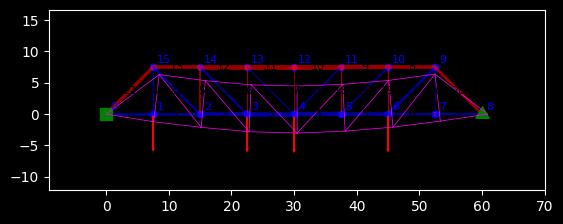

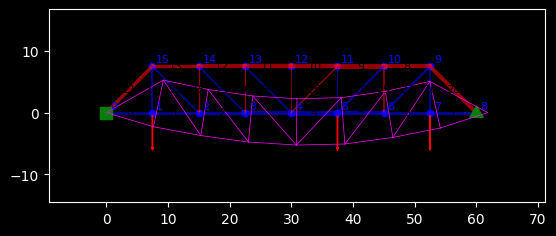

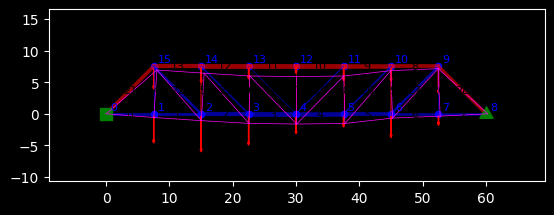

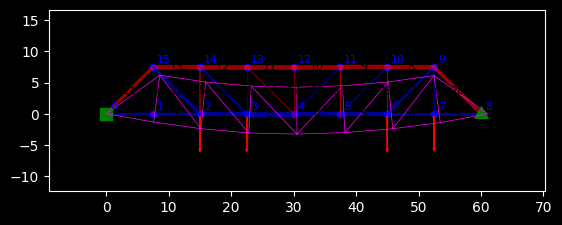

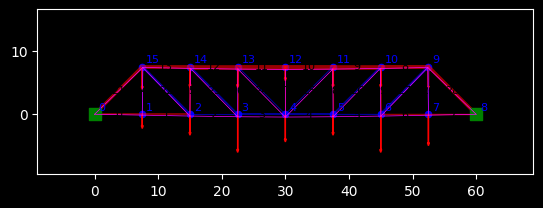

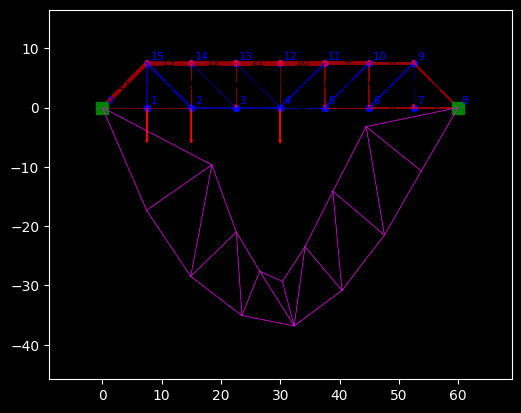

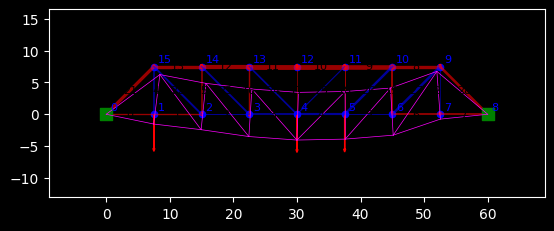

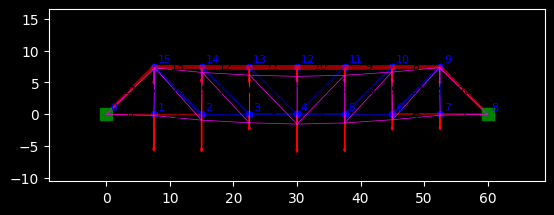

In [7]:
for bisupported, type in zip([False, True], ['isostatic', 'hyperstatic']):
    dir_path = f"data/dataset/pratt_truss_bridge_{type}"

    for size in [2 ** i for i in range(7, 15)]:
        routine(size, dirpath=dir_path, bisupported=bisupported)

    generate_dataset(2 ** 13,
                     uniform_ea_ratio=1.0, three_ea_ratio=0., random_ea_ratio=0.,
                     random_load_ratio=.8, shared_load_ratio=.2,
                     filepath=f'{dir_path}/test/0_uniform_8192.hdf5', bisupported=bisupported)
    generate_dataset(2 ** 13,
                     uniform_ea_ratio=0., three_ea_ratio=1., random_ea_ratio=0.,
                     random_load_ratio=.8, shared_load_ratio=.2,
                     filepath=f'{dir_path}/test/1_category_8192.hdf5', bisupported=bisupported)
    generate_dataset(2 ** 13,
                     uniform_ea_ratio=0., three_ea_ratio=0., random_ea_ratio=1.,
                     random_load_ratio=.8, shared_load_ratio=.2,
                     filepath=f'{dir_path}/test/2_member_8192.hdf5', bisupported=bisupported)
    generate_dataset(2 ** 13,
                     uniform_ea_ratio=.34, three_ea_ratio=.33, random_ea_ratio=.33,
                     random_load_ratio=.8, shared_load_ratio=.2,
                     filepath=f'{dir_path}/test/3_mixed_8192.hdf5', bisupported=bisupported)

In [1]:
ds = FixedPrattTrussDatasetSingleTarget("Flamant/generation/data/dataset/pratt_truss_bridge_hyperstatic_test/0_uniform_ea/train_4096.hdf5")
(ds.bars_strain[0] * ds.bars_area[0] * ds.bars_young[0] - ds.bars_force[0]).round(3)

NameError: name 'FixedPrattTrussDatasetSingleTarget' is not defined

In [10]:
ds.external_load[0].reshape((-1, 2)) / 1000.

array([[   0.        ,    0.        ],
       [   0.        , -657.78734628],
       [   0.        ,  -36.66168638],
       [   0.        ,    0.        ],
       [   0.        , -193.34315322],
       [   0.        ,    0.        ],
       [   0.        , -518.91137939],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ]])